In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load the CSV file
df = pd.read_csv("cleaned_legal_metadata.csv")

# Extract case type from docket number
def extract_case_type(docket):
    docket = str(docket).upper()
    if 'CR' in docket:
        return 'Criminal'
    elif 'CV' in docket or 'CIVIL' in docket:
        return 'Civil'
    elif 'MDL' in docket:
        return 'MDL'
    else:
        return 'Other'

df['case_type'] = df['docket_number'].apply(extract_case_type)

# Focus on major classes only
df = df[df['case_type'].isin(['Civil', 'Criminal', 'Other'])]

# Prepare features and labels
X_text = df['name'].astype(str)
y = df['case_type']

# Vectorize case name text
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(X_text)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))


Random Forest Classification Report:
              precision    recall  f1-score   support

       Civil       0.75      1.00      0.86        12
    Criminal       1.00      0.25      0.40         4
       Other       1.00      0.50      0.67         2

    accuracy                           0.78        18
   macro avg       0.92      0.58      0.64        18
weighted avg       0.83      0.78      0.73        18



In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Step 1: Load data
df = pd.read_csv("cleaned_legal_metadata.csv")

# Step 2: Derive target variable from 'docket_number'
def extract_case_type(docket):
    docket = str(docket).upper()
    if 'CR' in docket:
        return 'Criminal'
    elif 'CV' in docket or 'CIVIL' in docket:
        return 'Civil'
    elif 'MDL' in docket:
        return 'MDL'
    else:
        return 'Other'

df['case_type'] = df['docket_number'].apply(extract_case_type)
df = df[df['case_type'].isin(['Civil', 'Criminal', 'Other'])]  # keep consistent classes

# Step 3: Prepare text and labels
X_text = df['name'].astype(str)
y = df['case_type']

# Step 4: Tokenize text
max_words = 5000
max_len = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_text)
X_seq = tokenizer.texts_to_sequences(X_text)
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Step 5: Encode labels
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)
y_cat = to_categorical(y_enc)  # for softmax output

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, test_size=0.2, random_state=42)

# Step 7: Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(3, activation='softmax'))  # 3 classes: Civil, Criminal, Other

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 8: Train model
print("Training LSTM...")
model.fit(X_train, y_train, epochs=5, batch_size=16, verbose=1)

# Step 9: Evaluate
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("\nLSTM Classification Report:")
print(classification_report(encoder.inverse_transform(y_true), encoder.inverse_transform(y_pred)))


Training LSTM...
Epoch 1/5


c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4891 - loss: 1.0916
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6787 - loss: 1.0215
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6787 - loss: 0.8980
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7047 - loss: 0.7917
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6353 - loss: 0.8412
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step

LSTM Classification Report:
              precision    recall  f1-score   support

       Civil       0.67      1.00      0.80        12
    Criminal       0.00      0.00      0.00         4
       Other       0.00      0.00      0.00         2

    accuracy                           0.67        18
   macro avg       0.22      0.33      0.27        18
weighted avg       0.44      0.67      0.53        18



c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Step 1: Load your dataset
df = pd.read_csv("cleaned_legal_metadata.csv")

# Step 2: Extract case types
def extract_case_type(docket):
    docket = str(docket).upper()
    if 'CR' in docket:
        return 'Criminal'
    elif 'CV' in docket or 'CIVIL' in docket:
        return 'Civil'
    elif 'MDL' in docket:
        return 'MDL'
    else:
        return 'Other'

df['case_type'] = df['docket_number'].apply(extract_case_type)
df = df[df['case_type'].isin(['Civil', 'Criminal', 'Other'])]

# Step 3: Prepare features and labels
X_text = df['name'].astype(str)
y = df['case_type']

# Step 4: Tokenize and pad sequences
max_words = 5000
max_len = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_text)
X_seq = tokenizer.texts_to_sequences(X_text)
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Step 5: Encode labels
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)
y_cat = to_categorical(y_enc)

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, test_size=0.2, random_state=42)

# Step 7: Build RNN model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(SimpleRNN(64))  # <-- SimpleRNN layer
model.add(Dense(3, activation='softmax'))  # 3 output classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 8: Train the model
print("Training Simple RNN...")
model.fit(X_train, y_train, epochs=5, batch_size=16, verbose=1)

# Step 9: Evaluate performance
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("\nSimple RNN Classification Report:")
print(classification_report(encoder.inverse_transform(y_true), encoder.inverse_transform(y_pred)))


Training Simple RNN...
Epoch 1/5


c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5368 - loss: 0.9528
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6921 - loss: 0.7501
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6756 - loss: 0.7822
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7151 - loss: 0.5823
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8885 - loss: 0.4387
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step

Simple RNN Classification Report:
              precision    recall  f1-score   support

       Civil       0.71      1.00      0.83        12
    Criminal       0.00      0.00      0.00         4
       Other       0.00      0.00      0.00         2

    accuracy                           0.67        18
   macro avg       0.24      0.33      0.28        18
weighted avg       0.47      0.67      0.55        18



c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\manas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

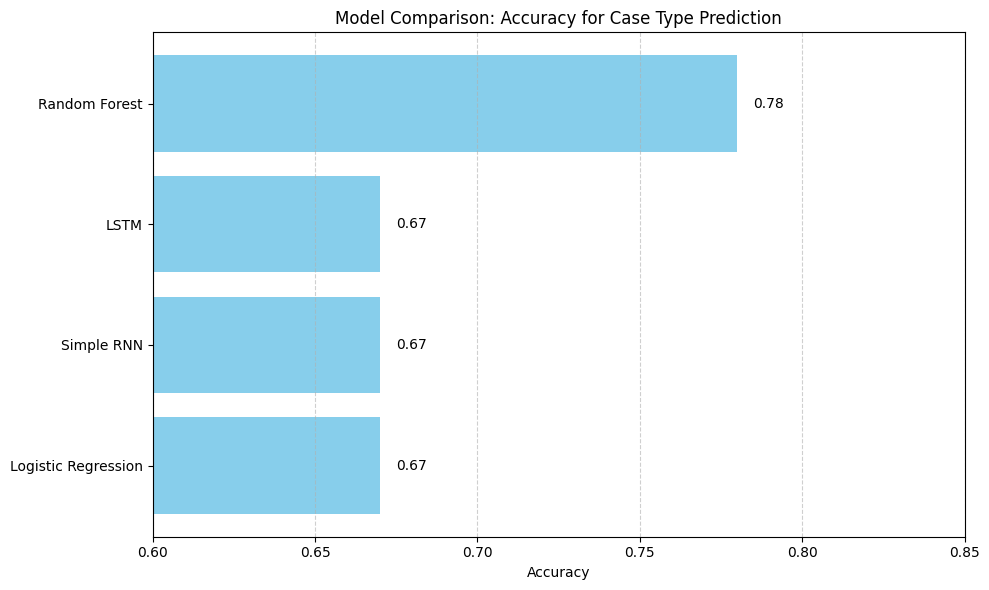

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace these with actual scores if available
results = {
    "Logistic Regression": 0.67,
    "Random Forest": 0.78,
    "Simple RNN": 0.67,
    "LSTM": 0.67
}

# Convert to DataFrame for plotting
df_results = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
df_results.sort_values("Accuracy", ascending=True, inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(df_results["Model"], df_results["Accuracy"], color='skyblue')
plt.xlabel("Accuracy")
plt.title("Model Comparison: Accuracy for Case Type Prediction")
plt.xlim(0.6, 0.85)

# Add accuracy values on bars
for bar in bars:
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}", va='center')

plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()
